In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import pandas as pd

try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets
    import ipywidgets

In [84]:
# Experiment parameters and thresholds
frame_rate = 300 # Hz
velocity_threshold = 0.5 # mm/s
acceleration_threshold = 10 # mm/s^2

### Threshold guidelines?
- possibly use relative threshold based on body weight? 
- perhaps an absolute threshold of velocity zero crossing is good enough 
- visual inspection? Kinda tedious. 

In [85]:
pickle_path = r"C:\Users\miken\DATA\ARGP\SAMPLE_ARGP_DATA\2022-08-29_Pilot_Data0002\generic_skelly_dict.pkl"

In [86]:
# open the saved file and load the dictionary using pickle
def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as f:
        generic_skelly_dict = pickle.load(f)
    return generic_skelly_dict

In [87]:
key_anatomical_points = list(generic_skelly_dict.keys())
print(key_anatomical_points)

['head_center_xyz', 'head_top_xyz', 'head_front_xyz', 'head_left_xyz', 'head_right_xyz', 'left_wrist_xyz', 'right_wrist_xyz', 'left_hand_xyz', 'right_hand_xyz', 'left_shoulder_xyz', 'right_shoulder_xyz', 'cspine_xyz', 'left_elbow_xyz', 'right_elbow_xyz', 'left_knee_xyz', 'right_knee_xyz', 'left_ankle_xyz', 'right_ankle_xyz', 'left_foot_xyz', 'right_foot_xyz', 'left_heel_xyz', 'right_heel_xyz', 'left_hip_xyz', 'right_hip_xyz', 'left_eyeball_center_xyz', 'right_eyeball_center_xyz']


In [88]:
# Extract the heel data from the dictionary
def extract_heel_data(generic_skelly_dict):
    left_heel_data = generic_skelly_dict['left_heel_xyz']
    right_heel_data = generic_skelly_dict['right_heel_xyz']
    return left_heel_data, right_heel_data
    

In [108]:
# Create a time vector
def create_time_vector(left_heel_data, frame_rate): # Could have used any key in the dictionary here
    time_vector = np.arange(0, len(left_heel_data)/frame_rate, 1/frame_rate)
    return time_vector

time_vector = create_time_vector(left_heel_data, frame_rate)

print(time_vector)

[0.00000000e+00 3.33333333e-03 6.66666667e-03 ... 1.11443333e+02
 1.11446667e+02 1.11450000e+02]


In [90]:
left_heel_data, right_heel_data = extract_heel_data(generic_skelly_dict)

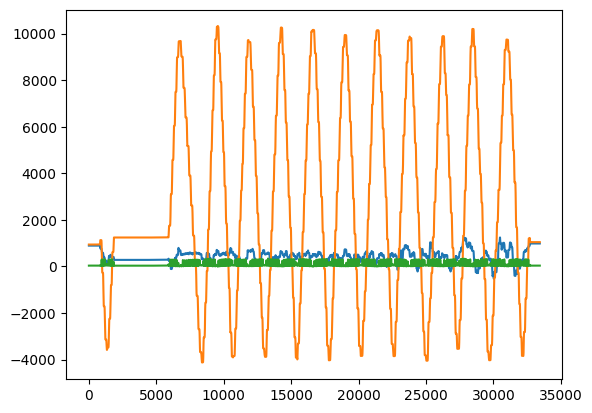

In [91]:
plt.plot(left_heel_data)
plt.show()

In [94]:
# Calculate the velocity and acceleration from position data
def calculate_velocity_acceleration(position_data, frame_rate):
    velocity_data = np.diff(position_data) * frame_rate
    acceleration_data = np.diff(velocity_data) * frame_rate
    return velocity_data, acceleration_data

# Find heel strikes based on velocity and acceleration (1D)
def find_heel_strikes_velocity_acceleration(heel_position_data, frame_rate, velocity_threshold, acceleration_threshold):
    # Extract the z-axis data
    heel_position_data_z = heel_position_data[:, 2]

    velocity_data, acceleration_data = calculate_velocity_acceleration(heel_position_data_z, frame_rate)

    heel_strike_indices = []
    for i in range(len(velocity_data)-1):  # Adjust the range to avoid index errors
        if velocity_data[i] < velocity_threshold and acceleration_data[i] > acceleration_threshold:
            heel_strike_indices.append(i+1)  # Add 1 to the index because diff causes you to lose one data point

    return heel_strike_indices

In [95]:
# Call the function for both left and right heel position data
left_heel_strikes_indices = find_heel_strikes_velocity_acceleration(left_heel_data, frame_rate, velocity_threshold, acceleration_threshold)
right_heel_strikes_indices = find_heel_strikes_velocity_acceleration(right_heel_data, frame_rate, velocity_threshold, acceleration_threshold)

In [96]:
# Get the heel strike times using the time vector
left_heel_strikes_times = time_vector[left_heel_strikes_indices]
right_heel_strikes_times = time_vector[right_heel_strikes_indices]

# Create a dictionary with left and right heel strikes
heel_strikes_dict = {
    'left': {
        'indices': left_heel_strikes_indices,
        'times': left_heel_strikes_times,
        'positions': left_heel_data[left_heel_strikes_indices]
    },
    'right': {
        'indices': right_heel_strikes_indices,
        'times': right_heel_strikes_times,
        'positions': right_heel_data[right_heel_strikes_indices]
    }
}



In [100]:
whats_in_here = list(heel_strikes_dict.keys())
print(whats_in_here)

['left', 'right']


In [103]:
r_heel_strike = list(heel_strikes_dict['right'].keys())
print(r_heel_strike)

['indices', 'times', 'positions']


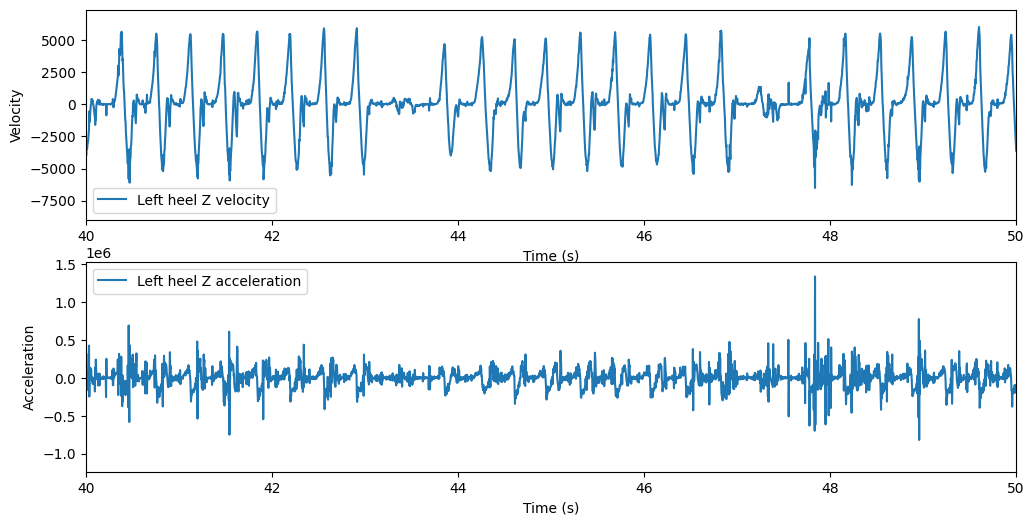

In [113]:
# debug plot to see if anything is actually showing 
left_heel_data_z = left_heel_data[:, 2]
left_heel_data_z_velocity, left_heel_data_z_acceleration = calculate_velocity_acceleration(left_heel_data_z, frame_rate)

# Plot the left heel's z-axis velocity and acceleration data
plt.figure(figsize=(12, 6))

time_vector_zv = time_vector[:-1] # Adjust the time vector to match the velocity and acceleration data
time_vector_za = time_vector[:-2] 

plt.subplot(2, 1, 1)
plt.plot(time_vector_zv, left_heel_data_z_velocity, label='Left heel Z velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.legend()
plt.xlim(40,50)

plt.subplot(2, 1, 2)
plt.plot(time_vector_za, left_heel_data_z_acceleration, label='Left heel Z acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.xlim(40,50)

plt.show()